<h1>Building a Convolutional Neural Network (CNN) to Detect COVID-19 in X-Ray Images</h1>
<h4>Anthony Preza</h4>
<p>In this notebook, we will load and preprocess X-ray data from <a href="https://github.com/ieee8023/covid-chestxray-dataset">this open soure dataset</a>. We will then build a CNN leveraging transfer learning from a ResNet50. The goal is to predict a diagnosis of COVID-19.</p>

In [1]:
import os

DATA_DIR = 'covid-chestxray-dataset'
NORMAL_DIR = 'chest_xray'
if DATA_DIR not in os.listdir():
    !git clone https://github.com/ieee8023/covid-chestxray-dataset
if NORMAL_DIR not in os.listdir():
    !kaggle datasets download paultimothymooney/chest-xray-pneumonia && unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

In [2]:
import sys
import logging
import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
tf.enable_eager_execution()

/home/anthony/projects/COVID-19-x-ray-cnn/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anthony/projects/COVID-19-x-ray-cnn/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anthony/projects/COVID-19-x-ray-cnn/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/a

<h4>Load and Preprocess Data</h4>
<p>We will determine the shape of the data and perform any preprocessing operations. In regards ato the data, we will be filtering the images down to x-ray view == PA. In order to use the ResNet50 base model, we prepare the data for transfer learning.</p>
<p>* Adding in normal images from <a href="https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia">this dataset</a>.

In [3]:
LOGGER = logging.getLogger(__name__)
LOGGER.setLevel(logging.INFO)
LOGGER.addHandler(logging.StreamHandler(stream=sys.stdout))
# determine number of images we will be working with
LOGGER.info(f'Number of images in covid image directory: %s', len(os.listdir(f"{DATA_DIR}/images")))

Number of images in covid image directory: 153


In [4]:
# load and visualize metadata
metadata = pd.read_csv(f'{DATA_DIR}/metadata.csv')
metadata.head()

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [5]:
metadata.shape

(149, 17)

In [6]:
# filter to only postoanterior images
metadata = metadata[metadata['view'] == 'PA']

In [7]:
image_filenames = metadata['filename']
labels = (metadata['finding'] == 'COVID-19')
LOGGER.info(f'Number of COVID-19 cases: %s/%s', len(metadata["finding"][labels]), len(metadata))

Number of COVID-19 cases: 71/94


In [8]:
data_to_process = tuple(zip(image_filenames, labels))
data_to_process[:5]

(('auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
  True),
 ('auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
  True),
 ('auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
  True),
 ('auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
  True),
 ('nejmc2001573_f1a.jpeg', True))

In [9]:
# visualize one image
# Image.open(f'{DATA_DIR}/images/{data_to_process[0][0]}')

In [10]:
# we will utilize the metadata to load and preprocess images
def load_and_preprocess_data(data=data_to_process, 
                             images_path=f'{DATA_DIR}/images'):
    
    def covid_img_generator(data=data, images_path=images_path):
        for filename, label in data:
            # read the image file
            img_str = tf.io.read_file(f'{images_path}/{filename}')
            # decode image as jpeg
            img_decoded = tf.image.decode_jpeg(img_str, channels=3)
            # cast image data to float32
            img = tf.cast(img_decoded, tf.float32)
            # resize image to proper shape
            resized_img = tf.image.resize(img, (224, 224))
            final_img = keras.applications.resnet50.preprocess_input(resized_img)
            yield final_img
    
    root_dir='chest_xray'
    img_dirs=['test', 'train', 'val']
    dirs = [f'{root_dir}/{dir_}/NORMAL' for dir_ in img_dirs]
    imgs = []
    for dir_ in dirs:
        imgs.extend([f'{dir_}/{filename}' for filename in os.listdir(dir_) if '.jpeg' in filename])
    imgs = imgs[:len(data)]

    def normal_img_generator(imgs=imgs):
        for filename in imgs:
            # read the image file
            img_str = tf.read_file(filename)
            # decode image as jpeg
            img_decoded = tf.image.decode_jpeg(img_str, channels=3)
            # cast image data to float32
            img = tf.cast(img_decoded, tf.float32)
            # resize image to proper shape
            resized_img = tf.image.resize(img, (224, 224))
            final_img = keras.applications.resnet50.preprocess_input(resized_img)
            yield final_img

    X = tf.stack([x for x in covid_img_generator()] + [y for y in normal_img_generator()], axis=0).numpy()
    y = [x[1] for x in data] + [0] * len(imgs)
    
    binarizer = LabelBinarizer()
    y = binarizer.fit_transform(y)
    y = keras.utils.to_categorical(y)
    
    return X, y

LOGGER.info('Loading and preprocessing data...')
X, y = load_and_preprocess_data()

Loading and preprocessing data...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


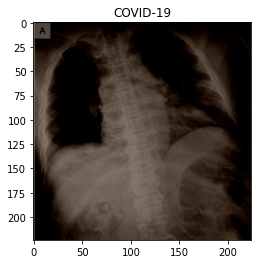

In [11]:
# visualize positive preprocessed image
plt.imshow(X[0] / 255.)
plt.title('COVID-19')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


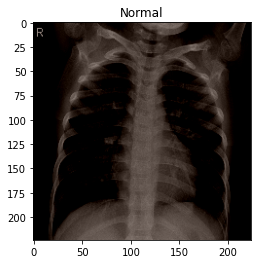

In [12]:
# visualize negative preprocessed image
plt.imshow(X[-1] / 255.)
plt.title('Normal')
plt.show()

<h4>Split data into training, validation, and testing sets</h4>
<p>Now that the data has been preprocessed, we can split it into training, validation, and testing sets. The training set will be used to train the CNN. Validation set is needed to validate hyperparamaters used to tune the model. Testing set will allow us to evaluate final performance.</p>

In [13]:
LOGGER.info('Full data shape: %s', X.shape)

Full data shape: (188, 224, 224, 3)


In [14]:
LOGGER.info('Splitting data into training, validation, and testing set...')
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, 
                                                              stratify=y,
                                                              test_size=0.2,
                                                              random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                              stratify=y_train_full,
                                                              test_size=0.3,
                                                              random_state=42)

Splitting data into training, validation, and testing set...


<h4>Build and Train CNN</h4>
<p>Here we will build a CNN using the ResNet50 architecture as a base model and adding a global pooling and dense layer to the top of the model (implementing dropout). We will train for 100 epochs, and implement early stopping with a patience of 10. The base model is frozen during the initial training session until the top layers are well trained, then all layers are unfrozen to continue training.</p>

In [15]:
LOGGER.info('Building CNN model...')
base_model = keras.applications.resnet50.ResNet50(weights='imagenet',
                                                 include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
norm = keras.layers.BatchNormalization()(avg)
dense = keras.layers.Dense(64, activation=keras.activations.relu)(norm)
dropout = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(20, activation=keras.activations.relu)(dropout)
dropout = keras.layers.Dropout(0.5)(dense)
output = keras.layers.Dense(2, activation=keras.activations.softmax)(dropout)
model = keras.Model(inputs=base_model.input, outputs=output)

Building CNN model...


/home/anthony/projects/COVID-19-x-ray-cnn/.venv/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [16]:
lr = 1.5e-3
for layer in base_model.layers:
    layer.trainable = False

LOGGER.info('Compiling model...')
model.compile(loss=keras.losses.binary_crossentropy, 
              optimizer=keras.optimizers.Adam(lr=lr, decay=lr / 10),
              metrics=['accuracy'])

LOGGER.info('Training top layers of model...')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Compiling model...
Training top layers of model...
Train on 105 samples, validate on 45 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
105/105 [==============================] - 15s 147ms/sample - loss: 1.6517 - acc: 0.3905 - val_loss: 0.4994 - val_acc: 0.9111
Epoch 2/10
105/105 [==============================] - 8s 73ms/sample - loss: 0.8894 - acc: 0.6762 - val_loss: 0.5857 - val_acc: 0.6889
Epoch 3/10
105/105 [==============================] - 8s 72ms/sample - loss: 0.6266 - acc: 0.7524 - val_loss: 0.6741 - val_acc: 0.5778
Epoch 4/10
105/105 [==============================] - 8s 74ms/sample - loss: 0.5731 - acc: 0.7143 - val_loss: 0.5010 - val_acc: 0.8667
Epoch 5/10
105/105 [==============================] - 8s 76ms/sample - loss: 0.5704 - acc: 0.7714 - val_loss: 0.3824 - val_acc: 0.8889
Epoch 6/10
105/105 [==============================] - 8s 75ms/sample - loss: 0.3800 - acc: 0.8381 - val_loss: 0.3601 - val_acc: 0.888

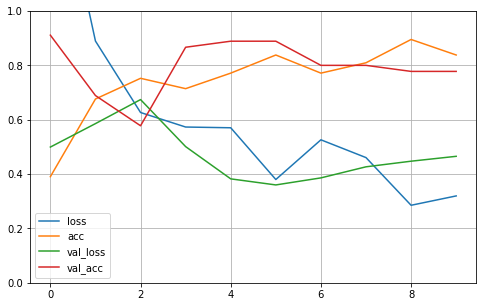

In [17]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [18]:
loss, acc = model.evaluate(X_test, y_test)
print(f'Initial loss: {loss}')
print(f'Initial accuracy: {acc}')

38/38 [==============================] - 3s 81ms/sample - loss: 0.3805 - acc: 0.8684
Initial loss: 0.3805245976699026
Initial accuracy: 0.8684210777282715


In [19]:
lr = 7.5e-5
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss=keras.losses.binary_crossentropy, 
              optimizer=keras.optimizers.Adam(lr=lr, decay=lr / 100),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_val, y_val), 
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 105 samples, validate on 45 samples
Epoch 1/100
105/105 [==============================] - 58s 551ms/sample - loss: 0.4158 - acc: 0.8286 - val_loss: 0.5628 - val_acc: 0.7556
Epoch 2/100
105/105 [==============================] - 37s 348ms/sample - loss: 0.3305 - acc: 0.8762 - val_loss: 0.6161 - val_acc: 0.7333
Epoch 3/100
105/105 [==============================] - 38s 358ms/sample - loss: 0.2145 - acc: 0.9238 - val_loss: 0.6526 - val_acc: 0.7333
Epoch 4/100
105/105 [==============================] - 36s 347ms/sample - loss: 0.1237 - acc: 0.9143 - val_loss: 0.6480 - val_acc: 0.7556
Epoch 5/100
105/105 [==============================] - 38s 359ms/sample - loss: 0.2254 - acc: 0.8857 - val_loss: 0.6269 - val_acc: 0.7556
Epoch 6/100
105/105 [==============================] - 38s 358ms/sample - loss: 0.3635 - acc: 0.8571 - val_loss: 0.6933 - val_acc: 0.7333
Epoch 7/100
105/105 [==============================] - 36s 343ms/sample - loss: 0.1276 - acc: 0.9429 - val_loss: 0.7643 - val_a

In [20]:
loss, acc = model.evaluate(X_test, y_test)
print(f'Final loss: {loss}')
print(f'Final accuracy: {acc}')

38/38 [==============================] - 3s 81ms/sample - loss: 0.3513 - acc: 0.9474
Final loss: 0.35129530046527324
Final accuracy: 0.9473684430122375


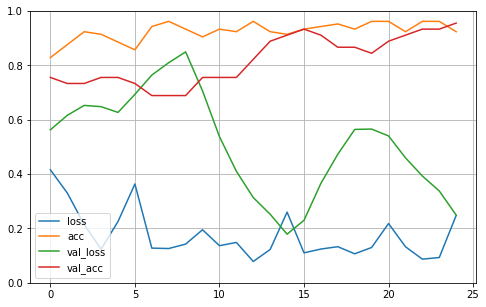

In [21]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()